In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab"

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../ump-dataset/train.parquet", columns=features)
target = pd.read_parquet("../ump-dataset/train.parquet", columns=["target",])
time = pd.read_parquet("../ump-dataset/train.parquet", columns=["time_id",])

In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.3
valid_size = int(valid_prop * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 363


In [5]:
valid_time_ids = time_ids[-valid_size:]

In [6]:
train_idx = time.query("time_id not in @valid_time_ids").index
valid_idx = time.query("time_id in @valid_time_ids").index

# dataframes for metric calculation
oof = target.loc[valid_idx,:].copy()
oof["time_id"] = time.loc[valid_idx,"time_id"]
features_valid = features.loc[valid_idx,:]

# input dataset for lgbm
train_dset = lgb.Dataset(
    data=features.loc[train_idx,:],
    label=target.loc[train_idx,"target"].values,
    free_raw_data=True
)
valid_dset = lgb.Dataset(
    data=features.loc[valid_idx,:],
    label=target.loc[valid_idx,"target"].values,
    free_raw_data=True
)

In [7]:
import gc
gc.collect()

44

***
## Bayesian Optimization

In [8]:
default_params = {
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 128,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': int(1e8),
    'feature_pre_filter' : False,
}

In [9]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [10]:
def objective(trial):    
    sampled_params = dict(
        max_bin = 2**trial.suggest_int("max_bin_exp", 6, 10) - 1,
        feature_fraction = trial.suggest_discrete_uniform("feature_fraction", 0.1, 0.5, 0.05),
        bagging_fraction = trial.suggest_discrete_uniform("bagging_fraction", 0.7, 1.0, 0.05),
        lambda_l1 = trial.suggest_loguniform("lambda_l1", 1e-3, 1e1),
        lambda_l2 = trial.suggest_loguniform("lambda_l2", 1e-3, 1e1),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 500, 2000, 100),
        path_smooth = trial.suggest_float("path_smooth", 0., 50.),
    )
    model_params = {**default_params, **sampled_params}
    
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=trial.suggest_int("num_iterations", 500, 2000, 100),
    )
    
    # metric calculation
    _oof = oof.copy()
    _oof["pred"] = model.predict(features_valid)
    corrs = _oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    
    return corr_mean            

In [11]:
do_optimize = False

study = optuna.create_study(
    study_name="lgbm-gbrt",
    direction='maximize',
    storage='sqlite:///lgbm-gbrt.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=43200, # 24-hrs
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2022-02-28 15:44:50,648] Using an existing study with name 'lgbm-gbrt' instead of creating a new one.


In [12]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin_exp,params_min_data_in_leaf,params_num_iterations,params_path_smooth,state
123,123,0.131592,2022-02-27 03:19:49.090188,2022-02-27 03:23:11.670457,0 days 00:03:22.580269,1.00,0.15,0.340640,3.248109,9,1900,800,48.076545,COMPLETE
112,112,0.131392,2022-02-27 02:07:13.242301,2022-02-27 02:13:27.220912,0 days 00:06:13.978611,1.00,0.30,0.202673,7.909433,10,2000,900,46.811813,COMPLETE
126,126,0.131216,2022-02-27 03:29:14.989655,2022-02-27 03:32:22.528475,0 days 00:03:07.538820,1.00,0.15,0.322399,9.836679,9,2000,700,25.598002,COMPLETE
125,125,0.131127,2022-02-27 03:26:07.319518,2022-02-27 03:29:14.880138,0 days 00:03:07.560620,1.00,0.15,0.589366,9.435494,9,2000,700,47.419782,COMPLETE
52,52,0.131066,2022-02-26 20:43:25.401627,2022-02-26 20:47:02.822879,0 days 00:03:37.421252,1.00,0.15,0.310993,0.013955,9,1700,900,24.421441,COMPLETE
128,128,0.131033,2022-02-27 03:34:59.333663,2022-02-27 03:37:49.057889,0 days 00:02:49.724226,1.00,0.15,0.459174,9.439906,9,2000,600,21.689652,COMPLETE
44,44,0.131005,2022-02-26 19:54:56.778942,2022-02-26 20:01:36.561373,0 days 00:06:39.782431,1.00,0.30,0.267045,4.456596,10,1800,1000,21.340842,COMPLETE
55,55,0.130976,2022-02-26 20:56:54.697353,2022-02-26 21:02:11.979504,0 days 00:05:17.282151,1.00,0.20,0.249238,0.012544,10,1900,1100,24.900167,COMPLETE
33,33,0.130949,2022-02-26 18:44:57.688180,2022-02-26 18:51:12.469741,0 days 00:06:14.781561,1.00,0.25,0.328501,4.277573,10,1600,1100,31.074651,COMPLETE
36,36,0.130938,2022-02-26 19:04:06.648102,2022-02-26 19:09:16.054779,0 days 00:05:09.406677,1.00,0.30,0.117371,5.432002,10,1800,700,22.868190,COMPLETE


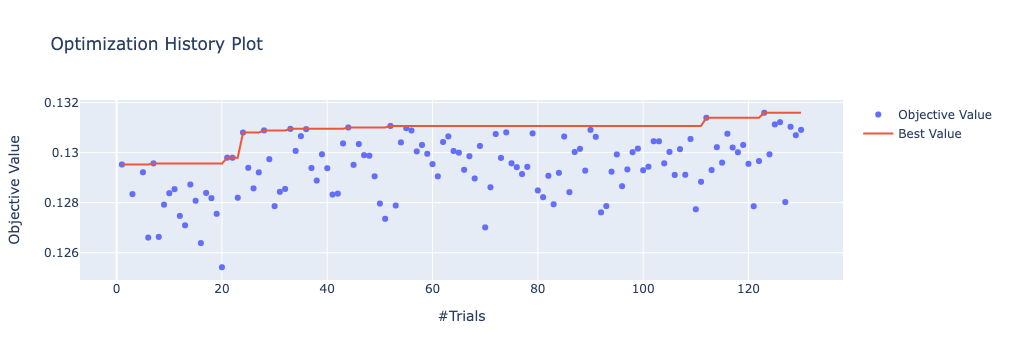

In [13]:
plot_optimization_history(study)

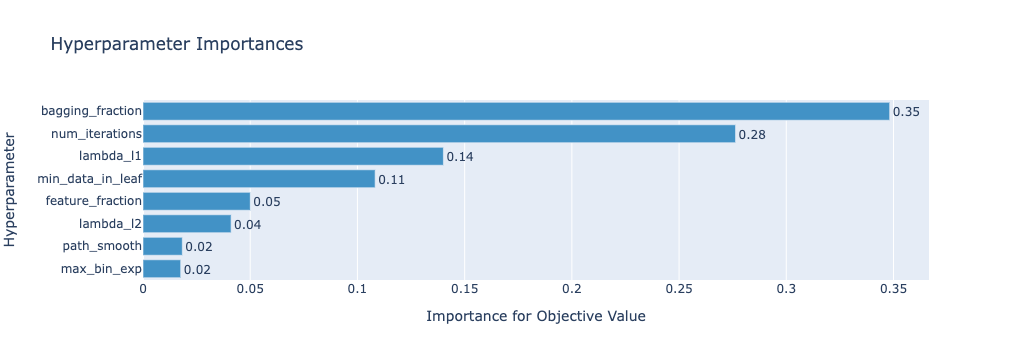

In [14]:
plot_param_importances(study)

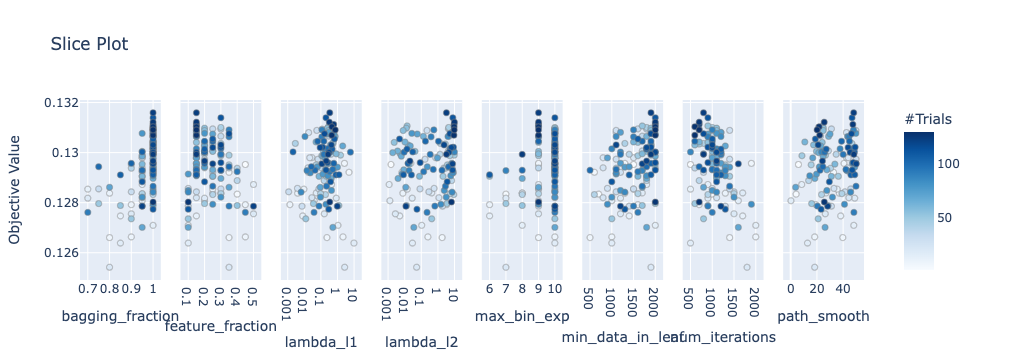

In [15]:
plot_slice(study)

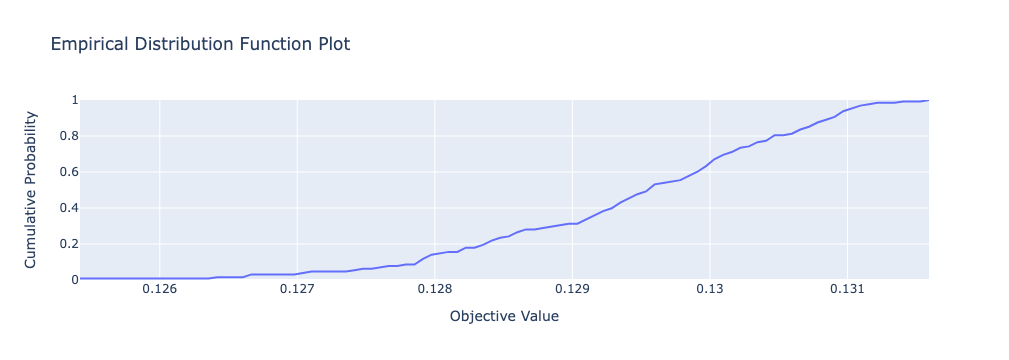

In [16]:
plot_edf(study)

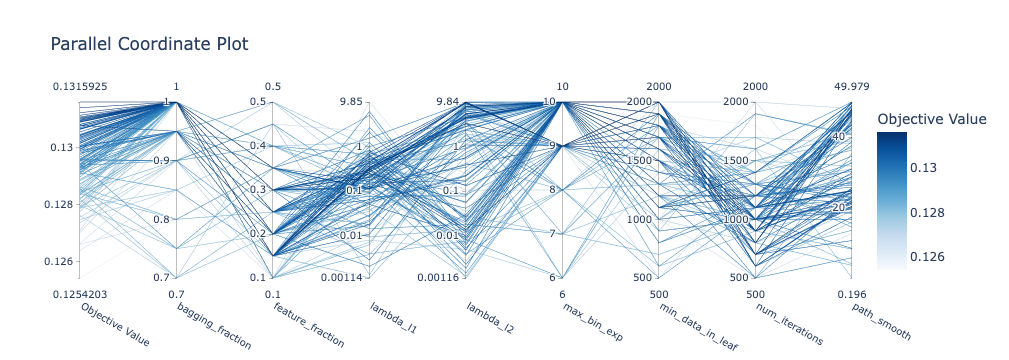

In [17]:
plot_parallel_coordinate(study)

In [18]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params = {**default_params, **best_params}
best_params

{'objective': 'mse',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'num_leaves': 128,
 'force_col_wise': True,
 'bagging_freq': 1,
 'seed': 19,
 'verbosity': -1,
 'first_metric_only': False,
 'bin_construct_sample_cnt': 100000000,
 'feature_pre_filter': False,
 'bagging_fraction': 1.0,
 'feature_fraction': 0.15000000000000002,
 'lambda_l1': 0.3406400464644552,
 'lambda_l2': 3.2481088372420728,
 'min_data_in_leaf': 1900,
 'num_iterations': 800,
 'path_smooth': 48.076544759497345,
 'max_bin': 511}

***